# Machine Learning course
## Assignment 2, Problem 2


### Import libraries

In [99]:
import pandas as pd # data processing
from sklearn.model_selection import train_test_split # split data into training and testing sets
import matplotlib.pyplot as plt # data visualization
import numpy as np # linear algebra

### Data Processing

In [100]:
# load data
file_path = 'circle_separator.txt'
data = pd.read_csv(file_path, header=None, sep=' ', names=['x', 'y', 'label']) # load data by splitting on space and naming columns
data.head()

,x,y,label
0,-0.17,0.64,1
1,-1.92,-0.42,-1
2,1.24,0.46,1
3,-1.81,-0.95,-1
4,-0.58,0.62,1


### Helper functions

In [101]:
# Helper function to generate line classifiers
# points = array of tuples (x, y)
# Returns: array of classifiers, each a function with signature h(x) -> {-1, 1}
def generate_line_classifiers(points):
    classifiers = []
    n_points = points.shape[0]

    for i in range(n_points):
        for j in range(i + 1, n_points):
            p1, p2 = points[i], points[j]

            # Line equation coefficients for line (p1, p2)
            a = p2[1] - p1[1] # y2 - y1
            b = p1[0] - p2[0] # x1 - x2
            c = p2[0] * p1[1] - p1[0] * p2[1] # x2 * y1 - x1 * y2

            # Classifier function for this line
            def classifier(point, a=a, b=b, c=c):
                result = a * point[0] + b * point[1] + c
                return 1 if result >= 0 else -1

            classifiers.append(classifier)

    return classifiers

In [102]:
# Helper function to generate circle classifiers
# same as generate_line_classifiers
def generate_circle_classifiers(points):
    classifiers = []
    n_points = len(points)

    for i in range(n_points):
        for j in range(n_points):
            if i != j:
                center = points[i]
                radius = np.linalg.norm(points[j] - points[i])

                # Define the classifier function for this circle
                def circle_classifier(point, center=center, radius=radius):
                    # Compute the distance from the point to the center
                    distance_from_center = np.linalg.norm(point - center)
                    # Classify the point as 1 if it's within the radius, -1 otherwise
                    return 1 if distance_from_center <= radius else -1

                classifiers.append(circle_classifier)

    return classifiers
    

In [103]:
# AdaBoost algorithm based on the pseudo-code in the lecture slides
def adaboost(samples, features, classifiers, iterations):

    result_classifiers = [] # store selected classifiers h_t
    alphas = [] # store classifiers weights alpha_t
    n_samples = samples.shape[0]
    
    D = np.ones(n_samples) / n_samples # 1.Initialize point weights
    
    for t in range(iterations): # 2. For iteration t = 1, 2, ..., k
        min_error = float('inf')
        best_classifier = None

        #3. Compute weighted error for each classifier
        for classifier in classifiers:
            empirical_error = 0
            for i in range(n_samples): 
                prediction = classifier(samples[i])
                empirical_error += D[i] * int(features[i] != prediction)

            #4. Select classifier with minimum weighted error
            if empirical_error < min_error: 
                min_error = empirical_error
                best_classifier = classifier

        #5. Set classifier weight alpha_t based on its error
        alpha_t = 0.5 * np.log((1 - min_error) / max(min_error, 1e-10)) # avoid division by zero
        alphas.append(alpha_t)
        
        #6. update point weights
        D_new = np.zeros_like(D)
        for i in range(n_samples):
            prediction = best_classifier(samples[i])
            D_new[i] = D[i] * np.exp(-alpha_t * features[i] * prediction)
        # Normalize point weights
        D = D_new / np.sum(D_new)

        result_classifiers.append(best_classifier)
        
        
    return alphas, result_classifiers

In [104]:
# Compute the error function from the assignment
def compute_error(H_k, alphas, X, y):
    n_samples = X.shape[0]
    combined_prediction = np.zeros(n_samples)

    for i in range(n_samples):
        for alpha, h in zip(alphas, H_k):
            combined_prediction[i] += alpha * h(X[i])

    # Sign of the combined prediction gives the final prediction
    final_prediction = np.sign(combined_prediction)

    # Calculate the error as the proportion of misclassified samples
    error = np.mean(final_prediction != y)

    return error

### Main function

In [105]:
# Main function to execute the AdaBoost
# data = input data
# n_runs = number of runs to average over
# iterations = number of iterations to run AdaBoost for
# classifiers_generator = function to generate classifiers
# Returns: average training and testing errors for each k
def execute_adaboost(data, n_runs, iterations, classifiers_generator):
    X = data[['x', 'y']].values
    y = data['label'].values
    avg_train_errors = np.zeros(iterations)
    avg_test_errors = np.zeros(iterations)

    for i in range(n_runs):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        # Generate classifiers
        classifiers = classifiers_generator(X_train)
        # Train the adaboost model
        alphas, result_classifiers = adaboost(X_train, y_train, classifiers, iterations)
        # Compute errors for each k
        for k in range(1, iterations + 1):
            # Compute the training error
            train_error = compute_error(result_classifiers[:k], alphas[:k], X_train, y_train)
            # Compute the testing error
            test_error = compute_error(result_classifiers[:k], alphas[:k], X_test, y_test)
            # Update the average errors
            avg_train_errors[k - 1] += train_error
            avg_test_errors[k - 1] += test_error

    # Calculate the average errors over all runs
    avg_train_errors /= n_runs
    avg_test_errors /= n_runs

    # Print out the average errors for each k
    for k in range(iterations):
        print(f"k = {k + 1}: Average Training error = {avg_train_errors[k]:.2f}, Average Testing error = {avg_test_errors[k]:.2f}")

    return avg_train_errors, avg_test_errors


## Results

In [106]:
# Helper function to visualize the average training and testing errors
def plot_adaboost_errors(avg_train_errors, avg_test_errors):
    # k values corresponding to the number of classifiers used
    k_values = list(range(1, len(avg_train_errors) + 1))

    plt.figure(figsize=(12, 6))

    # Plot average training errors
    plt.plot(k_values, avg_train_errors, label='Average Training Error', marker='o')

    # Plot average testing errors
    plt.plot(k_values, avg_test_errors, label='Average Testing Error', marker='s')

    plt.title('AdaBoost Average Errors')
    plt.xlabel('Number of Classifiers (k)')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.xticks(k_values)
    plt.show()

### Line classifiers

k = 1: Average Training error = 0.27, Average Testing error = 0.29
k = 2: Average Training error = 0.27, Average Testing error = 0.29
k = 3: Average Training error = 0.17, Average Testing error = 0.32
k = 4: Average Training error = 0.33, Average Testing error = 0.35
k = 5: Average Training error = 0.12, Average Testing error = 0.35
k = 6: Average Training error = 0.12, Average Testing error = 0.35
k = 7: Average Training error = 0.08, Average Testing error = 0.35
k = 8: Average Training error = 0.11, Average Testing error = 0.28


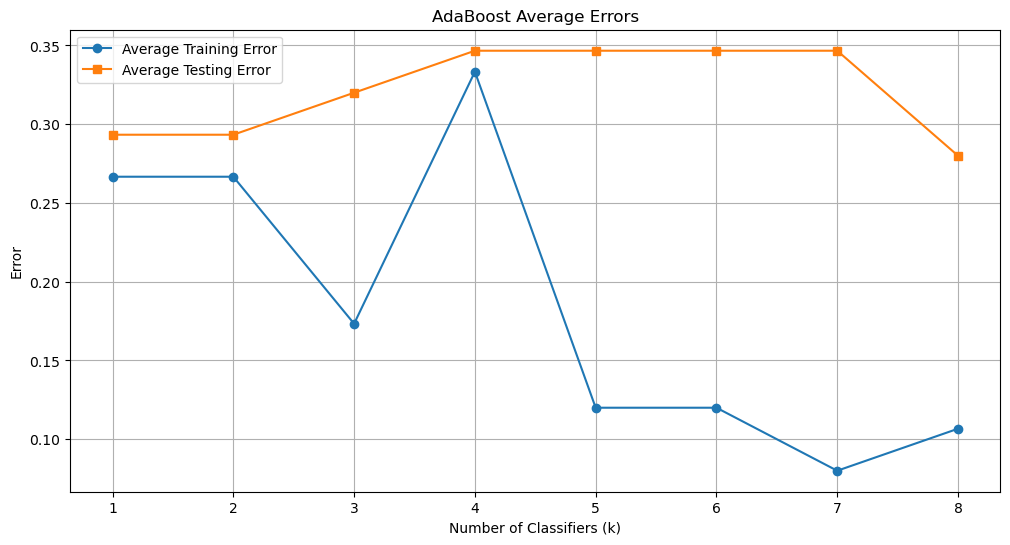

In [107]:
# Calculate the average training and testing errors for the line classifiers with 1 run
avg_train_e_lines_1, avg_test_e_lines_1 = execute_adaboost(data, 1, 8, generate_line_classifiers)
# Visualize the average training and testing errors
plot_adaboost_errors(avg_train_e_lines_1, avg_test_e_lines_1)

k = 1: Average Training error = 0.26, Average Testing error = 0.35
k = 2: Average Training error = 0.26, Average Testing error = 0.35
k = 3: Average Training error = 0.19, Average Testing error = 0.34
k = 4: Average Training error = 0.23, Average Testing error = 0.34
k = 5: Average Training error = 0.16, Average Testing error = 0.32
k = 6: Average Training error = 0.15, Average Testing error = 0.30
k = 7: Average Training error = 0.11, Average Testing error = 0.29
k = 8: Average Training error = 0.13, Average Testing error = 0.30


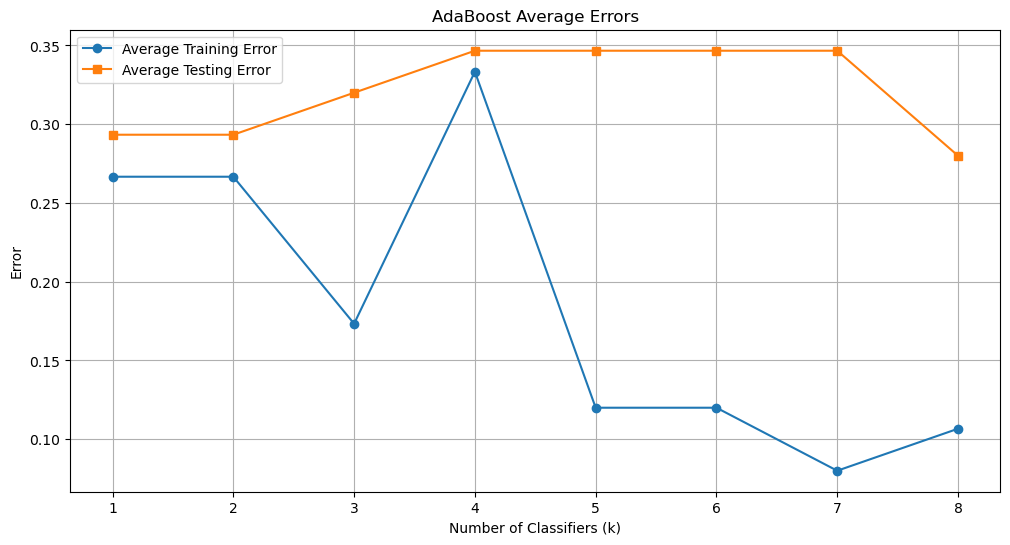

In [108]:
# Calculate the average training and testing errors for the line classifiers with 50 runs
avg_train_e_lines_50, avg_test_e_lines_50 = execute_adaboost(data, 50, 8, generate_line_classifiers)
# Visualize the average training and testing errors
plot_adaboost_errors(avg_train_e_lines_1, avg_test_e_lines_1)

For k= 1and k=2, both training and testing errors remain the same, indicating that the initial classifiers chosen are stable and do not overfit the data.
However, as k increases beyond 2 we start to see fluctuations in the testing error. This could be due to the AdaBoost model becoming more complex, and depending on the specific training data, it may start to overfit.
For 50 loops, the training error generally decreases as k increases, which is typical as the model fits the training data better with more classifiers. However, the testing error does not increase as much as in the single loop scenario, suggesting that averaging over multiple loops helps in mitigating overfitting.
The fact that the testing error decreases or remains stable as k increases in the 50 loop case suggests that the model is generalizing well overall. The AdaBoost algorithm is effectively combining the weak classifiers to improve the model's performance on unseen data

### Circle classifiers

k = 1: Average Training error = 0.03, Average Testing error = 0.08
k = 2: Average Training error = 0.03, Average Testing error = 0.08
k = 3: Average Training error = 0.00, Average Testing error = 0.07
k = 4: Average Training error = 0.01, Average Testing error = 0.08
k = 5: Average Training error = 0.00, Average Testing error = 0.01
k = 6: Average Training error = 0.00, Average Testing error = 0.01
k = 7: Average Training error = 0.00, Average Testing error = 0.05
k = 8: Average Training error = 0.00, Average Testing error = 0.05


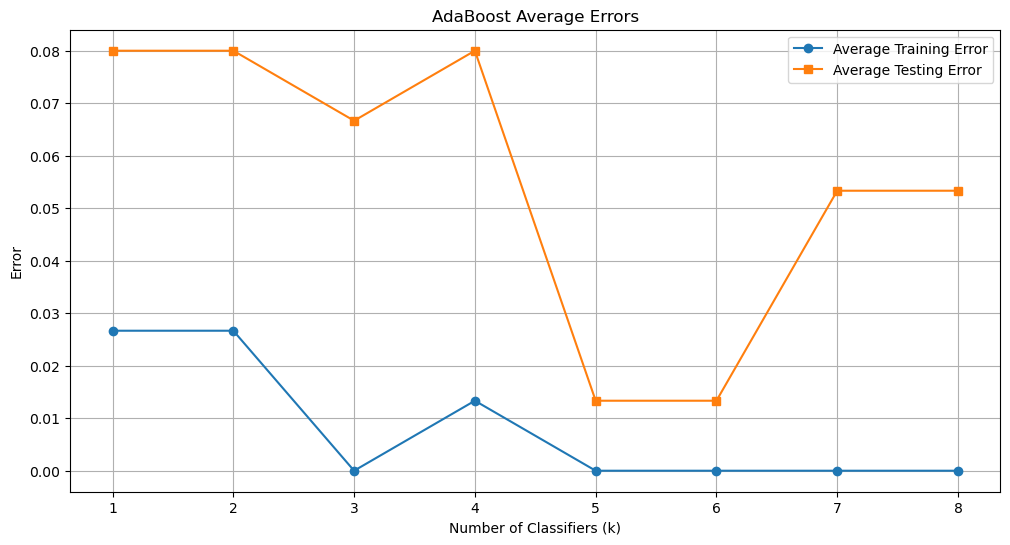

In [109]:
# Calculate the average training and testing errors for the circle classifiers with 1 run
avg_train_e_circles_1, avg_test_e_circles_1 = execute_adaboost(data, 1, 8, generate_circle_classifiers)
# Visualize the average training and testing errors
plot_adaboost_errors(avg_train_e_circles_1, avg_test_e_circles_1)

k = 1: Average Training error = 0.03, Average Testing error = 0.07
k = 2: Average Training error = 0.04, Average Testing error = 0.07
k = 3: Average Training error = 0.01, Average Testing error = 0.04
k = 4: Average Training error = 0.01, Average Testing error = 0.04
k = 5: Average Training error = 0.00, Average Testing error = 0.04
k = 6: Average Training error = 0.00, Average Testing error = 0.04
k = 7: Average Training error = 0.00, Average Testing error = 0.03
k = 8: Average Training error = 0.00, Average Testing error = 0.03


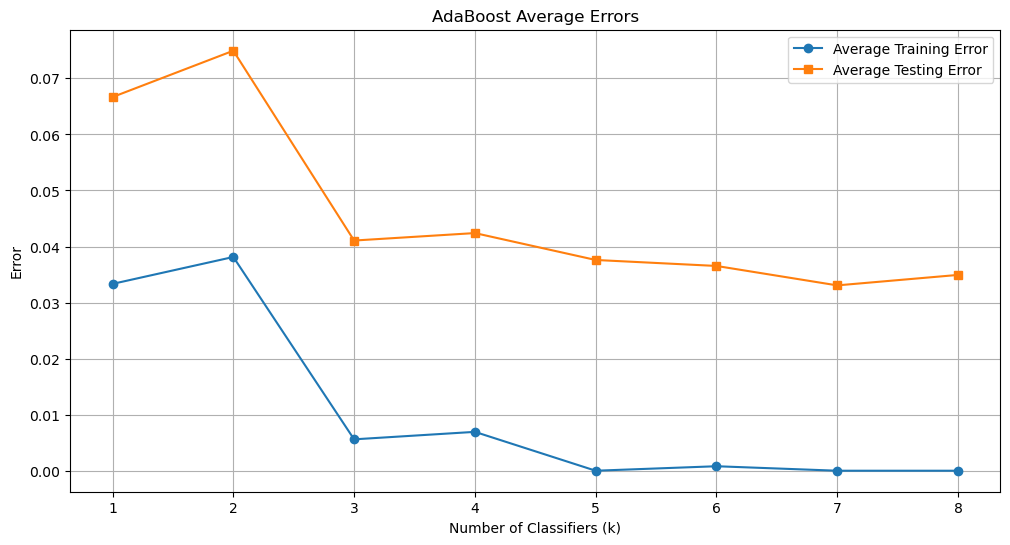

In [110]:
# Calculate the average training and testing errors for the circle classifiers with 50 runs
avg_train_e_circles_50, avg_test_e_circles_50 = execute_adaboost(data, 50, 8, generate_circle_classifiers)
# Visualize the average training and testing errors
plot_adaboost_errors(avg_train_e_circles_50, avg_test_e_circles_50)

The circle classifiers seem to be a particularly good hypothesis for this dataset, which could suggest the data has a circular distribution or circular decision boundarie.There is no clear evidence of overfitting.
The stability of the model is demonstrated by the low variation in testing errors from k=1 to k=8 across 50 loops. This stability is a good indicator that the model is not overly sensitive to the specific training set used.


### Summary

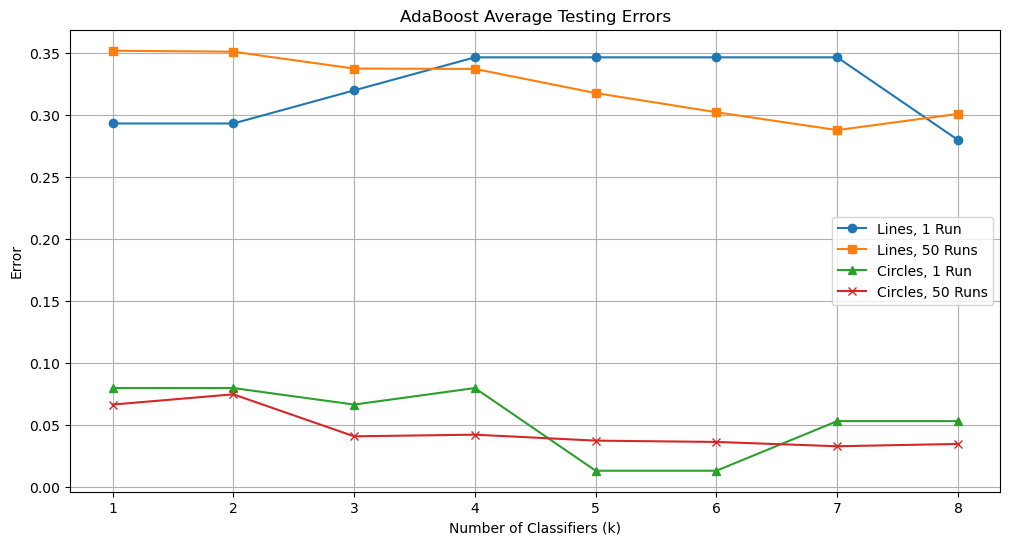

In [111]:
# Visualize the average testing errors for all cases
k_values = list(range(1, 9))
plt.figure(figsize=(12, 6))
plt.plot(k_values, avg_test_e_lines_1, label='Lines, 1 Run', marker='o')
plt.plot(k_values, avg_test_e_lines_50, label='Lines, 50 Runs', marker='s')
plt.plot(k_values, avg_test_e_circles_1, label='Circles, 1 Run', marker='^')
plt.plot(k_values, avg_test_e_circles_50, label='Circles, 50 Runs', marker='x')
plt.title('AdaBoost Average Testing Errors')
plt.xlabel('Number of Classifiers (k)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.xticks(k_values)
plt.show()

In summary, the AdaBoost algorithm with circle classifiers appears to be a better choice for this particular dataset, providing a more stable and accurate model than line classifiers. The low error rates and lack of significant increase in error with more classifiers suggest that the circle classifiers are capturing the underlying structure of the data without overfitting.
